In [2]:
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/15.8 MB ? eta -:--:--
     --                                       0.9/15.8 MB 27.5 MB/s eta 0:00:01
     -------                                  2.8/15.8 MB 36.1 MB/s eta 0:00:01
     ----------                               4.3/15.8 MB 34.3 MB/s eta 0:00:01
     ---------------                          6.2/15.8 MB 36.1 MB/s eta 0:00:01
     ------------------                       7.4/15.8 MB 33.6 MB/s eta 0:00:01
     ------------------------                10.0/15.8 MB 37.4 MB/s eta 0:00:01
     ----------------------------            11.7/15.8 MB 38.5 MB/s eta 0:00:01
     ----------------------------------      14.1/15.8 MB 43.5 MB/s eta 0:00:01
     --------------------------------------  15.8/15.8 MB 46.9 MB/s eta 0:00:01
     --------------------------------------  15.8/15.8 MB 46.9 MB/s eta 0:00:01
     --------------------------------------  15.8/


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install pandas

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/11.6 MB ? eta -:--:--
     ----                                     1.3/11.6 MB 26.8 MB/s eta 0:00:01
     -----------------                        5.2/11.6 MB 54.9 MB/s eta 0:00:01
     ------------------------------           9.0/11.6 MB 71.8 MB/s eta 0:00:01
     --------------------------------------  11.6/11.6 MB 81.8 MB/s eta 0:00:01
     --------------------------------------  11.6/11.6 MB 81.8 MB/s eta 0:00:01
     --------------------------------------  11.6/11.6 MB 81.8 MB/s eta 0:00:01
     --------------------------------------  11.6/11.6 MB 81.8 MB/s eta 0:00:01
     --------------------------------------  11.6/11.6 MB 81.8 MB/s eta 0:00:01
     --------------------------------------  11.6/11.6 MB 81.8 MB/s eta 0:00:01
     --------------------------------------- 11.6/11.6 MB 27.3 MB/s eta 0:00:00
                                              0.0/


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install networkx

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
                                              0.0/1.7 MB ? eta -:--:--
     ----------------------------------       1.5/1.7 MB 45.1 MB/s eta 0:00:01
     ---------------------------------------  1.7/1.7 MB 35.9 MB/s eta 0:00:01
     ---------------------------------------- 1.7/1.7 MB 18.0 MB/s eta 0:00:00


In [5]:
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/8.0 MB ? eta -:--:--
     ---                                      0.8/8.0 MB 24.4 MB/s eta 0:00:01
     --------------------                     4.2/8.0 MB 53.2 MB/s eta 0:00:01
     --------------------------------------   7.6/8.0 MB 60.6 MB/s eta 0:00:01
     ---------------------------------------  8.0/8.0 MB 56.8 MB/s eta 0:00:01
     ---------------------------------------  8.0/8.0 MB 56.8 MB/s eta 0:00:01
     ---------------------------------------- 8.0/8.0 MB 34.0 MB/s eta 0:00:00
                                              0.0/188.2 kB ? eta -:--:--
     -------------------------------------- 188.2/188.2 kB 5.6 MB/s eta 0:00:00
                                              0.0/2.2 MB ? eta -:--:--
     -------------------------------------    2.0/2.2 MB 65.7 MB/s eta 0:00:01
     ---------------------------------------  2.2/2.2 MB 70.7 MB/s eta 0:0


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
%pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/78.3 kB ? eta -:--:--
     ---------------------------------------- 78.3/78.3 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
from tqdm import tqdm
from networkx.drawing.nx_pydot import graphviz_layout
from collections import Counter

Matplotlib is building the font cache; this may take a moment.


# Base para todos

[other works](https://petsymposium.org/popets/2020/popets-2020-0023.pdf)

## Kalebe implementations

exponential mechanism

In [8]:
def exp_mechanism_k(data, score_func, list_outputs, epsilon, global_sensivity, target = None):
    scores = [score_func(data, out, target) if target != None else score_func(data, out) for out in list_outputs]
    probs = [np.exp(epsilon * score / (2 * global_sensivity)) for score in scores]
    probs_normalizadas = probs / np.linalg.norm(probs, ord=1)

    return np.random.choice(list_outputs, 1, p=probs_normalizadas)[0]

local dampening mechanism

In [430]:
def dampening_function_k(data, output, score_func, delta_func, target = None):
    b_list = [0]
    i = 0  
    b_list.append(delta_func(data, i, output) if target == None else delta_func(data, i, output, target))
    
    score = score_func(data, output, target) if target != None else score_func(data, output)
    # print(output)
    while True:
        if (score >= 0 and (score < b_list[-2] or score >= b_list[-1])) or (score < 0 and (score < -b_list[-1] or score >= -b_list[-2])):
            # print(f"Não ainda\nb0:{b_list[-2]}\nb1:{b_list[-1]}\nscore:{score}\nOutput:{output}")
            i += 1
            d_func = delta_func(data, i, output) if target == None else delta_func(data, i, output, target)
            b_list[-2] = b_list[-1]
            b_list[-1] += d_func
            continue
        # print(f"calculated!")
        D_val = (score - b_list[-2]) / (b_list[-1] - b_list[-2]) + i if score > 0 else (score + b_list[-2]) / np.abs(-b_list[-1] + b_list[-2]) - i
        # if D_val == 0:
        #     print(D_val, output, score, b_list, i)
        #     print("-"*50)
        # print(D_val, score, b_list, score >= 0, i)
        return D_val

def local_dampening_mechanism_k(data, score_func, delta_func, list_outputs, epsilon, target = None):
    scores = np.array([dampening_function_k(data, out, score_func, delta_func, target) if target != None else dampening_function_k(data, out, score_func, delta_func) for out in list_outputs])
    # print(scores == 0)
    # scores = (scores - scores.mean()) / scores.std()
    probs = [np.exp(epsilon * score / 2) for score in scores]
    probs_normalizadas = probs / np.linalg.norm(probs, ord=1)
    return np.random.choice(list_outputs, 1, p=probs_normalizadas)[0]

permute and flip mechanism

In [10]:
def permute_and_flip_k(data, score_func, list_outputs, epsilon, global_sensivity, target = None):
    max_score = max([score_func(data, out, target) if target else score_func(data, out) for out in list_outputs])
    # aqui talvez seja interessante copiar e passar a copia da list_ouputs
    np.random.shuffle(list_outputs)
    for r in list_outputs:
        prob = np.exp(epsilon * (score_func(data, r, target) - max_score) / (2 * global_sensivity))
        if np.random.rand() < prob:
            return r

## Darlan implementations

In [424]:
def Local_Dampening_Mechanism(u_r, sensibilidade, r_id, G, target):
    if u_r >= 0:
        
        t = 0
        bt0 = 0
        bt1 = sensibilidade(G, 0, r_id, target)
        
        while True:
            if ((bt0 <= u_r) and  (u_r < bt1)):
                print("Saiu do loop", r_id)
                break
            print(f"Não ainda\nb0:{bt0}\nb1:{bt1}\nscore:{u_r}\nOutput:{r_id}")
            t += 1
            bt0 = bt1
            bt1 += sensibilidade(G, t, r_id, target)
    elif u_r < 0:

        t = 0
        bt0 = 0
        bt1 = -sensibilidade(G, 0, r_id, target)
        
        while True:

            if ((bt1 <= u_r) and  (u_r < bt0)):
                break
            
            t -= 1
            bt0 = bt1
            bt1 -= sensibilidade(G, -t, r_id, target)
    
    D = (u_r - bt0) / np.abs(bt1 - bt0) + t
    
    return D

def local_dampening_mechanism_d(data, score_func, delta_func, list_outputs, epsilon, target = None):
    scores = np.array([Local_Dampening_Mechanism(score_func(data, out, target), delta_func, out, data, target) for out in list_outputs])
    # scores = (scores - scores.mean())/scores.std()
    probs = [np.exp(epsilon * score / 2) for score in scores]
    probs_normalizadas = probs / np.linalg.norm(probs, ord=1)
    return np.random.choice(list_outputs, 1, p=probs_normalizadas)[0]


# Algoritmo 7

In [397]:
def get_new_candidate(candidates, tau, atual):
    new_candidates = []
    for candidate in candidates[atual:]:
        if candidate[0] > 0 and candidate[1] > 0:
            new_candidates.append((candidate[0] - 1, candidate[1] - 1))
        if candidate[0]  < tau:
            new_candidates.append((candidate[0] + 1, candidate[1]))
    return new_candidates

def h_func(x, y):
    def f_func(x, somar = False):
        if (x <= 0 and somar) or (x <= 1 and not somar):
           return 0
        return x * np.log2((x + 1) / x) + np.log2(x + 1) if somar else x * np.log2((x - 1) / x) - np.log2(x - 1)
    return max(f_func(x, True) - f_func(y, True), f_func(x) - f_func(y))

big = {}

def local_sensivity_at_tDistance_alg7(data:pd.DataFrame, t:float, col_val, target):
    '''
    data = dataframe

    t = distâncuia

    col_val = uma coluna do dataframe

    target_values = lista com todas saídas possíveis do label
    '''

    if not col_val in big:
        big[col_val] = {}
    
    if not t in big[col_val]:
        H = []
        if t == 0:
            candidatos = []
            for j_val in data[col_val].unique():
                recorte_Aj = data[data[col_val] == j_val]
                for c_val in recorte_Aj[target].unique():
                    recorte_Ajc = recorte_Aj[recorte_Aj[target] == c_val]
                    candidatos.append((len(recorte_Aj), len(recorte_Ajc)))
                    H.append(h_func(len(recorte_Aj), len(recorte_Ajc)))
            big[col_val][t] = max(H)
            big[col_val]["candidatos"] = candidatos
            big[col_val]["atual"] = 0
        else:
            new_candidates = get_new_candidate(big[col_val]["candidatos"], data.shape[0], big[col_val]["atual"])
            for x, y in new_candidates:
                H.append(h_func(x,y))
            big[col_val][t] = max(max(H), big[col_val][t - 1])
            big[col_val]["candidatos"] += new_candidates
            big[col_val]["atual"] += len(new_candidates)

    return big[col_val][t]

In [405]:
def noisy_count(data: pd.DataFrame, target, epsilon):
    # Contagem exata da coluna alvo
    exact_count = data[target].shape[0]
    
    noise = np.random.laplace(scale = 1 / epsilon)
    # Adicionar o ruído ao contador exato
    noisy_count = exact_count + np.abs(noise)
    # print("exact->  ", exact_count)
    # print("noisy->  ", noisy_count)
    # print("Epsilon-> ", epsilon)
    # print("-"*50)
    # print(np.abs(noisy_count))
    return noisy_count

# Equação 7.2
def score_func_alg7(data: pd.DataFrame, r_col, target):
    '''
    r_col = uma coluna específica do dataframe
    '''
    infGain_list = []
    for j_val in data[r_col].unique():
        data_colR_valA = data[data[r_col] == j_val]
        tau_j = data_colR_valA.shape[0]
        for c_val in data_colR_valA[target].unique():

            data_colR_valA_outC = data_colR_valA[data_colR_valA[target] == c_val]
            tau_jc = data_colR_valA_outC.shape[0]
            # print(tau_j, tau_jc, j_val, c_val)
            infGain_list.append(tau_jc * np.log2(tau_jc / tau_j))
    
    # print(infGain_list)
    # if sum(infGain_list) == 0:
    #     print(r_col)
    return -sum(infGain_list)

def score_func_shifted_alg7(data, r_col, target):
    n = len(data)
    lista_colunas = data.columns.to_list()
    lista_colunas.remove(target)
    max_score = max(score_func_alg7(data, out, target) for out in lista_colunas)

    return score_func_alg7(data, r_col, target) - n * (np.log2(n + 1) + 1/np.log(2)) - max_score

def build_diff_PID3(data:pd.DataFrame, list_columns: list, target, 
                    profundidade, epsilon, typo, pai = None):
    data_target_list = data[target].unique()
    # print(list_columns, profundidade)
    if len(list_columns) == 0 or profundidade == 0:
        data_output_partitions = [noisy_count(data[data[target] == c], target, epsilon) for c in data_target_list]
        # print("->", len(data))
        max_Nc = max(data_output_partitions)
        leaf = data_target_list[data_output_partitions.index(max_Nc)]
        name_node = f"{leaf}" 
        name_node = name_node + f":id:{pai}" if pai != None else name_node
        # print("retornou aqui list and depth", name_node)
        return name_node
    
    t_val = max([len(data[col].unique()) for col in list_columns])
    N_t = noisy_count(data, target, epsilon)

    if N_t / (t_val * len(data_target_list)) < np.sqrt(2)/2:
        data_output_partitions = [noisy_count(data[data[target] == c], target, epsilon) for c in data_target_list]
        max_Nc = max(data_output_partitions)
        leaf = data_target_list[data_output_partitions.index(max_Nc)]
        name_node = f"{leaf}" 
        name_node = name_node + f":id:{pai}" if pai != None else name_node
        # print("retornou noisy countt", name_node)
        return name_node
    
    if typo == "exp":
        columns_hat = exp_mechanism_k(data, score_func_alg7, list_columns, epsilon, np.log2(data.shape[0] + 1) + 1/np.log(2), target)
    elif typo == "ld":
        columns_hat = local_dampening_mechanism_k(data, score_func_alg7, local_sensivity_at_tDistance_alg7, list_columns, epsilon, target)
    
    # columns_hat = local_dampening_mechanism_d(data, score_func_shifted_alg7, local_sensivity_at_tDistance_alg7, list_columns, epsilon, target)
    # print("-"*50)
    # print(data[columns_hat].unique())
    data_i = [(data[data[columns_hat] == i], i ) for i in data[columns_hat].unique()]
    lista_copiada = list_columns.copy()
    lista_copiada.remove(columns_hat)
    arvore = []
    # print("NEWM AQUI CHEGOU")

    for dado in data_i:
        node = build_diff_PID3(dado[0], lista_copiada, target, profundidade - 1, epsilon, typo, f"{columns_hat}{dado[1]}")
        # print(columns_hat, node, dado[1] ,profundidade)
        arvore.append({
            "from": columns_hat,
            "to": node,
            "edge_name": dado[1]
        })
    
    # print("retornou certo, in theory", arvore)
    return arvore

def global_diff_PID3(data:pd.DataFrame, target, profundidade: int, privacy_budget: float, typo: str):
    '''
    data = um dataframe
    target = a coluna alvo, no exemplo do tempo, seria o Y e o N
    profundidade = numero que indica a profuntidade
    privacy_budget = nivel de privacidade numero
    '''
    epsilon = privacy_budget / (2 * (profundidade + 1))
    lista_colunas = data.columns.to_list()
    lista_copiada = lista_colunas.copy()
    lista_copiada.remove(target)
    big = {}
    # print(data, lista_colunas, target, profundidade, epsilon)
    # print("--"*50)
    # print("\n")
    arvore = build_diff_PID3(data, lista_copiada, target, profundidade, epsilon, typo)
    # print(arvore, lista_copiada)
    return arvore

def molde2draw(molde):
    G = nx.DiGraph()
    lista_labels = {}

    def add_edge(from_name, to_name, edge_label):
        if isinstance(to_name, list):
            for item in to_name:
                to_name = item["from"]
                add_edge(item["from"], item["to"], item["edge_name"])
            
        G.add_edge(from_name, to_name)
        lista_labels[(from_name, to_name)] = edge_label

    for dict_node in molde:
        add_edge(dict_node["from"], dict_node["to"], dict_node["edge_name"])

    root = molde[0]["from"]
    pos = nx.bfs_layout(G, root)
    nx.draw(
        G, pos, edge_color='black', width=1, linewidths=1,
        node_size=500, node_color='pink', alpha=0.9,
        labels={node: node.split(":id:")[0] for node in G.nodes()}
    )
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=lista_labels,
        font_color='red'
    )
    plt.axis('off')
    plt.show()

In [14]:
dict_data = {
    "Outlook": ["rain", "rain", "sun", "sun", "sun"],
    "Wind": ["strong", "weak", "strong", "weak", "strong"],
    "Decision": ["y", "n", "y", "n", "n"]
}

data_example = pd.DataFrame(dict_data)
data_example

,Outlook,Wind,Decision
0,rain,strong,y
1,rain,weak,n
2,sun,strong,y
3,sun,weak,n
4,sun,strong,n


Nesse caso, se o epsilon for muito grande, o score cresce para infinito e se for muito pequeno retorna somente um nó (no mecanismo exponencial, o outro nem roda)

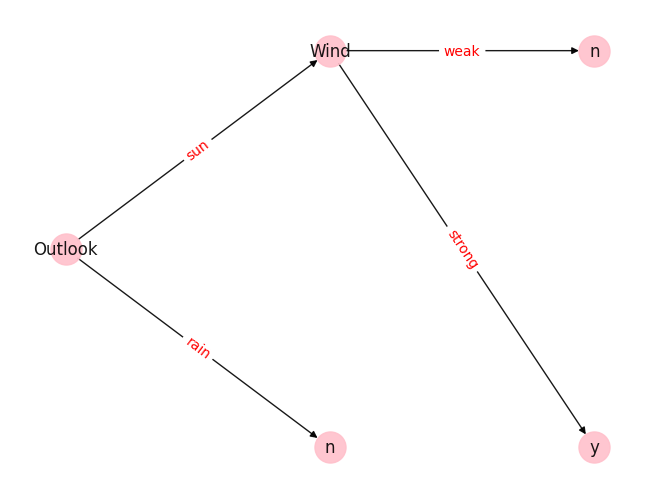

[{'from': 'Outlook', 'to': 'n:id:Outlookrain', 'edge_name': 'rain'}, {'from': 'Outlook', 'to': [{'from': 'Wind', 'to': 'y:id:Windstrong', 'edge_name': 'strong'}, {'from': 'Wind', 'to': 'n:id:Windweak', 'edge_name': 'weak'}], 'edge_name': 'sun'}]


In [176]:
# Atribua um valor de privacidade para o orçamento de privacidade
epsilon = 1000

# Chame a função global_diff_PID3 para construir a árvore de decisão diferencial com privacidade global
arvore_molde_example = global_diff_PID3(data_example, "Decision", 2, epsilon, "ld")
molde2draw(arvore_molde_example)
print(arvore_molde_example)

In [177]:
car_data = pd.read_csv("./car_evalueate.csv")
car_data

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


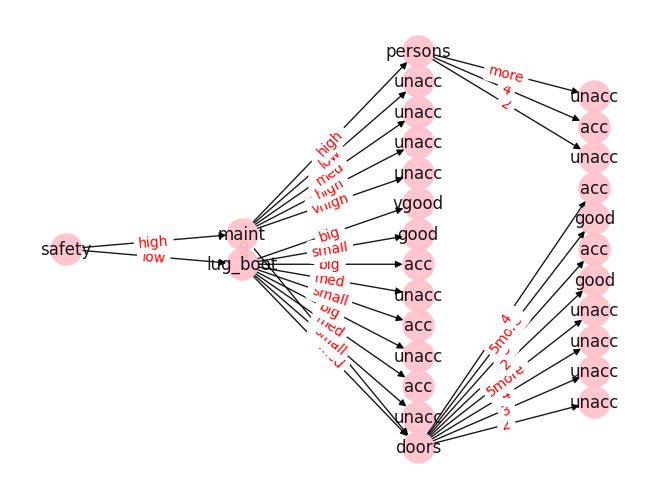

[{'from': 'safety', 'to': [{'from': 'lug_boot', 'to': [{'from': 'maint', 'to': 'unacc:id:maintvhigh', 'edge_name': 'vhigh'}, {'from': 'maint', 'to': 'unacc:id:mainthigh', 'edge_name': 'high'}, {'from': 'maint', 'to': 'unacc:id:maintmed', 'edge_name': 'med'}, {'from': 'maint', 'to': 'unacc:id:maintlow', 'edge_name': 'low'}], 'edge_name': 'small'}, {'from': 'lug_boot', 'to': [{'from': 'doors', 'to': 'unacc:id:doors2', 'edge_name': '2'}, {'from': 'doors', 'to': 'unacc:id:doors3', 'edge_name': '3'}, {'from': 'doors', 'to': 'unacc:id:doors4', 'edge_name': '4'}, {'from': 'doors', 'to': 'unacc:id:doors5more', 'edge_name': '5more'}], 'edge_name': 'med'}, {'from': 'lug_boot', 'to': [{'from': 'maint', 'to': 'unacc:id:maintvhigh', 'edge_name': 'vhigh'}, {'from': 'maint', 'to': 'unacc:id:mainthigh', 'edge_name': 'high'}, {'from': 'maint', 'to': 'unacc:id:maintmed', 'edge_name': 'med'}, {'from': 'maint', 'to': 'unacc:id:maintlow', 'edge_name': 'low'}], 'edge_name': 'big'}], 'edge_name': 'low'}, {'f

In [178]:
epsilon = 1/10000
# Chame a função global_diff_PID3 para construir a árvore de decisão diferencial com privacidade global
arvore_molde_car = global_diff_PID3(car_data, "class", 3, epsilon, "ld")
# print(arvore_molde_car)
molde2draw(arvore_molde_car)
print(arvore_molde_car)

In [179]:
row = []
with open("./breast-cancer.data") as f:
    for r in f:
        row.append(r.split(","))

cancer_data = pd.DataFrame(row, columns = ["Class", "age", "menopause", "tumor-size", "inv-nodes", "nodes-caps", "deg-malig", "breast", "breast-quad", "irradiat"])
cancer_data = cancer_data.replace({"recurrence-events":"y", "no-recurrence-events":"n"})
cancer_data

,Class,age,menopause,tumor-size,inv-nodes,nodes-caps,deg-malig,breast,breast-quad,irradiat
0,n,30-39,premeno,30-34,0-2,no,3,left,left_low,no\n
1,n,40-49,premeno,20-24,0-2,no,2,right,right_up,no\n
2,n,40-49,premeno,20-24,0-2,no,2,left,left_low,no\n
3,n,60-69,ge40,15-19,0-2,no,2,right,left_up,no\n
4,n,40-49,premeno,0-4,0-2,no,2,right,right_low,no\n
...,...,...,...,...,...,...,...,...,...,...
281,y,30-39,premeno,30-34,0-2,no,2,left,left_up,no\n
282,y,30-39,premeno,20-24,0-2,no,3,left,left_up,yes\n
283,y,60-69,ge40,20-24,0-2,no,1,right,left_up,no\n
284,y,40-49,ge40,30-34,3-5,no,3,left,left_low,no\n


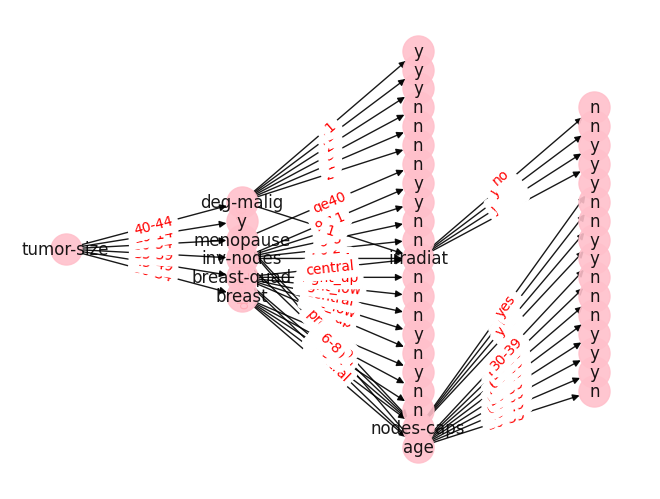

In [180]:
epsilon = 0.1
arvore_molde_cancer = global_diff_PID3(cancer_data, "Class", 3, epsilon, "ld")
molde2draw(arvore_molde_cancer)

In [181]:
cogumelos = pd.read_csv("./muschroom.csv")
cogumelos_cleaned = cogumelos.dropna(axis=1)
cogumelos_cleaned

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,k,s,n,f,n,a,c,b,y,e,...,o,o,p,o,o,p,b,c,l,e
8120,x,s,n,f,n,a,c,b,y,e,...,o,o,p,n,o,p,b,v,l,e
8121,f,s,n,f,n,a,c,b,n,e,...,o,o,p,o,o,p,b,c,l,e
8122,k,y,n,f,y,f,c,n,b,t,...,w,w,p,w,o,e,w,v,l,p


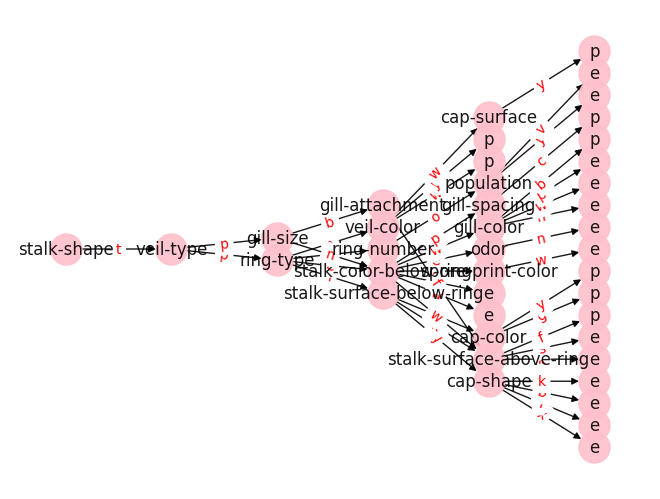

In [182]:
epsilon = 0.1
arvore_molde_mush = global_diff_PID3(cogumelos_cleaned, "poisonous", 5, epsilon, "ld")
# print(arvore_molde_mush)
molde2draw(arvore_molde_mush)

In [183]:
obesity = pd.read_csv("./obesidade.csv")
obesity
c_drop = []
for c in obesity.columns:
    if len(obesity[c].unique()) > 10:
        c_drop.append(c)

obesity_categorical = obesity.drop(columns=c_drop)
obesity_categorical

,Gender,CALC,FAVC,SCC,SMOKE,family_history_with_overweight,CAEC,MTRANS,NObeyesdad
0,Female,no,no,no,no,yes,Sometimes,Public_Transportation,Normal_Weight
1,Female,Sometimes,no,yes,yes,yes,Sometimes,Public_Transportation,Normal_Weight
2,Male,Frequently,no,no,no,yes,Sometimes,Public_Transportation,Normal_Weight
3,Male,Frequently,no,no,no,no,Sometimes,Walking,Overweight_Level_I
4,Male,Sometimes,no,no,no,no,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...
2106,Female,Sometimes,yes,no,no,yes,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,Sometimes,yes,no,no,yes,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,Sometimes,yes,no,no,yes,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,Sometimes,yes,no,no,yes,Sometimes,Public_Transportation,Obesity_Type_III


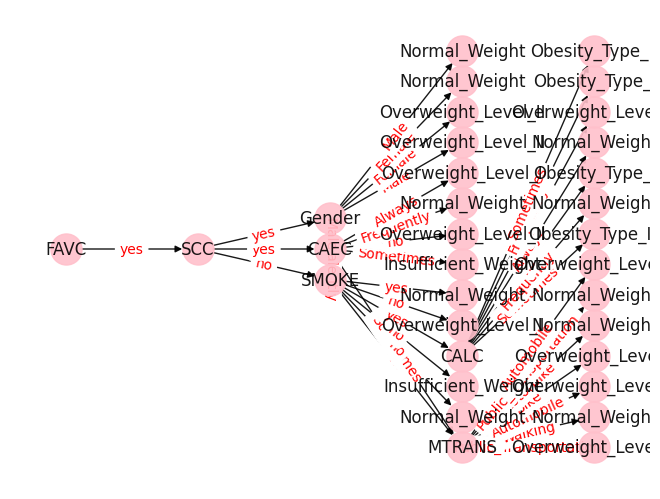

In [442]:
epsilon = 2
arvore_molde_obesity = global_diff_PID3(obesity_categorical, "NObeyesdad", 4, epsilon, "ld")
molde2draw(arvore_molde_obesity)

In [441]:
rows = []
with open("nltcs.test.wdata") as f:
    for row in f:
        rows.append(row.split("|")[1].split(","))

with open("nltcs.valid.wdata") as f:
    for row in f:
        rows.append(row.split("|")[1].split(","))

with open("nltcs.train.wdata") as f:
    for row in f:
        rows.append(row.split('|')[1].split(","))

columns = [f"c{i+1}" for i in range(15)]
columns.append("target")
data_nltcs = pd.DataFrame(rows, columns=columns)
data_nltcs

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,target
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0\n
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1\n
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0\n
4,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0\n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4442,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0\n
4443,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0\n
4444,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1\n
4445,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1\n


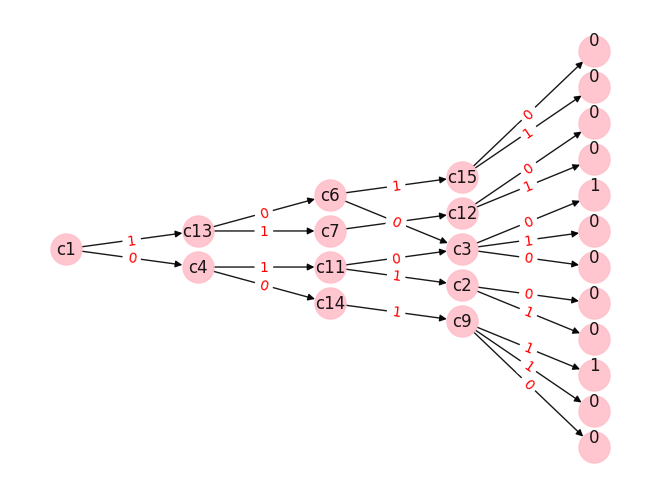

In [447]:
epsilon = 0.1
arvore_molde_obesity = global_diff_PID3(data_nltcs, "target", 4, epsilon, "ld")
molde2draw(arvore_molde_obesity)

In [400]:
data_adults = pd.read_csv("./adults.csv")
columns = []
for c in data_adults.columns:

    if len(data_adults[c].unique()) > 70:
        # print(len(data_adults[c].unique()))
        columns.append(c)

    # if len(data_adults[c].unique()) > 10:
    #     print(c)

data_adults_categorical = data_adults.drop(columns = columns)
print("shape data: ", data_adults_categorical.shape)
data_adults_categorical_limpo = data_adults_categorical.dropna()
print("shape droping Nan", data_adults_categorical_limpo.shape)
# print(data_adults_categorical_limpo[data_adults_categorical_limpo["native-country"] == "United-States"]["income"].unique())
cleaning = {
    '<=50K.':'<=50K',
    '>50K.':'>50K'
}
data_adults_categorical_limpo = data_adults_categorical_limpo.replace(cleaning)
# print(data_adults_categorical_limpo[data_adults_categorical_limpo["native-country"] == "United-States"]["income"].unique())
data_adults_categorical_limpo



shape data:  (48842, 10)
shape droping Nan (47621, 10)


,workclass,education,education-num,marital-status,occupation,relationship,race,sex,native-country,income
0,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...
48836,Private,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,United-States,<=50K
48837,Private,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,United-States,<=50K
48839,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
48840,Private,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,United-States,<=50K


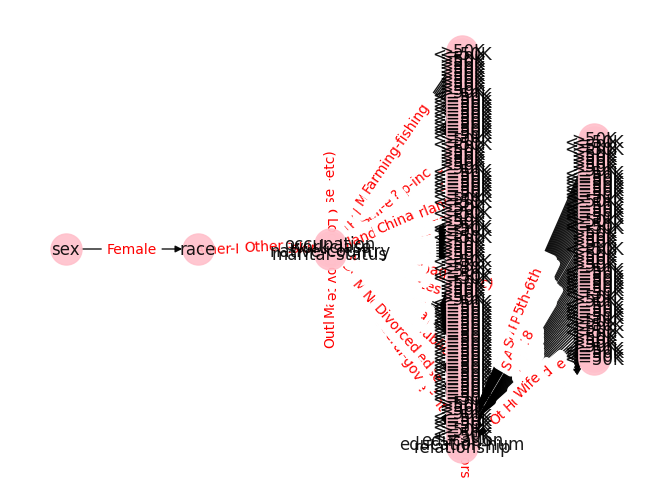

[{'from': 'sex', 'to': [{'from': 'race', 'to': [{'from': 'marital-status', 'to': [{'from': 'relationship', 'to': [{'from': 'workclass', 'to': '<=50K:id:workclassState-gov', 'edge_name': 'State-gov'}, {'from': 'workclass', 'to': '<=50K:id:workclassLocal-gov', 'edge_name': 'Local-gov'}, {'from': 'workclass', 'to': '<=50K:id:workclassPrivate', 'edge_name': 'Private'}, {'from': 'workclass', 'to': '<=50K:id:workclassFederal-gov', 'edge_name': 'Federal-gov'}, {'from': 'workclass', 'to': '<=50K:id:workclassSelf-emp-not-inc', 'edge_name': 'Self-emp-not-inc'}, {'from': 'workclass', 'to': '<=50K:id:workclass?', 'edge_name': '?'}, {'from': 'workclass', 'to': '>50K:id:workclassSelf-emp-inc', 'edge_name': 'Self-emp-inc'}], 'edge_name': 'Not-in-family'}, {'from': 'relationship', 'to': [{'from': 'native-country', 'to': '<=50K:id:native-countryUnited-States', 'edge_name': 'United-States'}, {'from': 'native-country', 'to': '<=50K:id:native-countryMexico', 'edge_name': 'Mexico'}, {'from': 'native-countr

In [431]:
epsilon = 0.5

# Chame a função global_diff_PID3 para construir a árvore de decisão diferencial com privacidade global
arvore_molde_adults = global_diff_PID3(data_adults_categorical_limpo, "income", 5, epsilon, "ld")
molde2draw(arvore_molde_adults)
print(arvore_molde_adults)

In [404]:
for c in data_adults_categorical_limpo.columns:
    print(data_adults_categorical_limpo[c].unique())
    print(c)
    print("-"*50)

['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
workclass
--------------------------------------------------
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
education
--------------------------------------------------
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
education-num
--------------------------------------------------
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
marital-status
--------------------------------------------------
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
occupation
---------------------------------------

## AVALIANDO ALGORITMO 7

In [199]:
def get_tree_dict(molde):
    my_dict = {}
    def pp(molde, depth = 0):
        if isinstance(molde["to"], list):
            for item in molde["to"]:
                pp(item, depth + 1)
            my_dict[(molde["from"], molde["edge_name"], depth)] = molde["to"][0]["from"]
            # print(molde["from"], molde["to"][0]["from"], molde["edge_name"])
        else:
            my_dict[(molde["from"], molde["edge_name"], depth)] = molde["to"]

    for it in molde:
        # print(it)
        pp(it)
    return my_dict

def predict_labels(df, tree, targets, target):
    def traverse_tree(row, tree):
        current_node = tree[0][0][0]
        next_node = None
        for node in tree:
            (node_col, node_val, depth), next_col = node
            # print(row, node_col)
            if node_col == current_node and row[node_col] == node_val:
                if next_col in targets:
                    return next_col
                else:
                    current_node = next_col
        return None  # Caso não encontre uma correspondência

    predicted_labels = []
    certas = 0
    for _, row in df.iterrows():
        prediction = traverse_tree(row, tree)
        if row[target] == prediction:
            certas += 1
        predicted_labels.append(prediction)
    
    return predicted_labels, certas / len(df)

def cross_validation(data, depth, epsilon, target, typo, n_folds=5):
    # Embaralhar os dados
    shuffled_indices = np.random.permutation(len(data))
    data = data.iloc[shuffled_indices].reset_index(drop=True)

    # Dividir os dados em n_folds partes
    fold_size = len(data) // n_folds
    accuracies = []

    for fold in range(n_folds):
        # Índices para o conjunto de teste e treino
        test_start = fold * fold_size
        test_end = test_start + fold_size
        if fold == n_folds - 1:
            test_end = len(data)  # Certifica-se de pegar todos os dados no último fold
        
        data_test = data.iloc[test_start:test_end]
        data_train = pd.concat([data.iloc[:test_start], data.iloc[test_end:]], axis=0)

        # Fazer previsões
        arvore_molde = global_diff_PID3(data_test, target, depth, epsilon, typo)
        dict_tree = get_tree_dict(arvore_molde)
        dict_tree = sorted(dict_tree.items(), key=lambda item: item[0][2])
        dict_tree = [(x[0], x[1].split(":id:")[0]) for x in dict_tree]
        _, accuracy = predict_labels(data_train, dict_tree, data_train[target].unique(), target)
        accuracies.append(accuracy)

    # Retornar a acurácia média
    mean_accuracy = sum(accuracies) / len(accuracies)
    return mean_accuracy

def make_test(data, target, epsilons, depths, typo, name_dataset, n_folds = 5, n_amostras = 10):
    results = {}
    for depth in depths:
        mean_accuracy = []

        for epsilon in epsilons:
            acuracia_media = np.mean([cross_validation(data, depth, epsilon, target, typo, n_folds = n_folds) for k in range(n_amostras)])
            results[(depth, epsilon)] = acuracia_media
            mean_accuracy.append(acuracia_media)
            print(f"Profundidade - {depth}\nEpsilon - {epsilon}\nAccuracy mean - {acuracia_media}")
        
        plt.plot(epsilons, mean_accuracy, color = "red")
        plt.title(f"Dataset {name_dataset} at {depth} depth with {typo} mechanism {n_amostras} amostras")
        plt.ylabel("Accuracy média")
        plt.xlabel("Epsilons")
        plt.show()

    return results

Profundidade - 2
Epsilon - 0.1
Accuracy mean - 0.5314544311358421
Profundidade - 2
Epsilon - 0.5
Accuracy mean - 0.5990935898645037
Profundidade - 2
Epsilon - 1.0
Accuracy mean - 0.6490599515860291
Profundidade - 2
Epsilon - 2.0
Accuracy mean - 0.6760624037222169


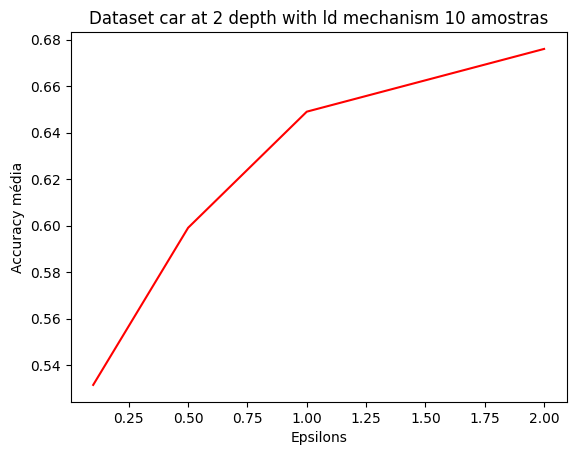

Profundidade - 4
Epsilon - 0.1
Accuracy mean - 0.5842399635323335
Profundidade - 4
Epsilon - 0.5
Accuracy mean - 0.5574916847433117
Profundidade - 4
Epsilon - 1.0
Accuracy mean - 0.5765315791128296
Profundidade - 4
Epsilon - 2.0
Accuracy mean - 0.5910762991606149


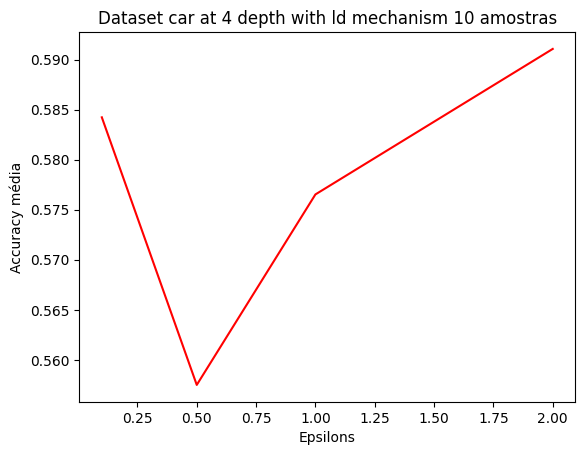

In [202]:
epsilons = [0.1, 0.5, 1., 2.]
depths = [2,4]
results_car_ld = make_test(car_data, "class", epsilons, depths, "ld", name_dataset = "car", n_folds=5)

Profundidade - 2
Epsilon - 0.1
Accuracy mean - 0.5240180137696878
Profundidade - 2
Epsilon - 0.5
Accuracy mean - 0.5985034738595995
Profundidade - 2
Epsilon - 1.0
Accuracy mean - 0.6399046496274641
Profundidade - 2
Epsilon - 2.0
Accuracy mean - 0.6794801471281714


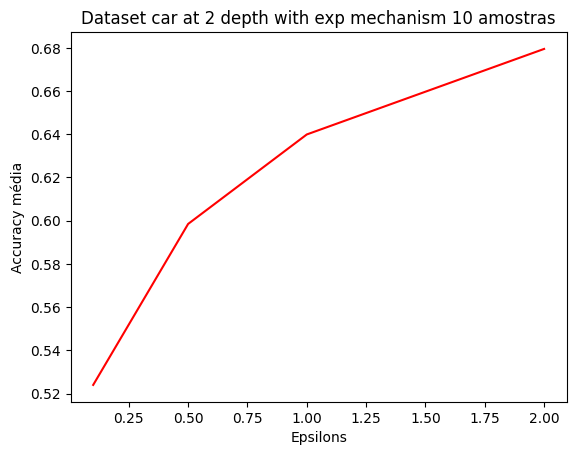

Profundidade - 4
Epsilon - 0.1
Accuracy mean - 0.5690733125844887
Profundidade - 4
Epsilon - 0.5
Accuracy mean - 0.6060773051652047
Profundidade - 4
Epsilon - 1.0
Accuracy mean - 0.5893335848344807
Profundidade - 4
Epsilon - 2.0
Accuracy mean - 0.5838988022257852


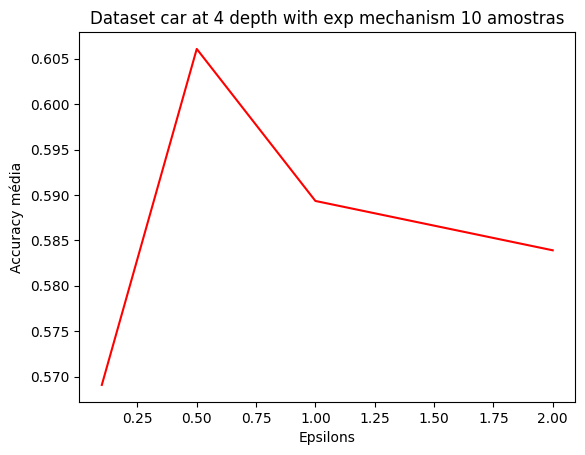

In [203]:
epsilons = [0.1, 0.5, 1., 2.]
depths = [2,4]
results_car_exp = make_test(car_data, "class", epsilons, depths, "exp", name_dataset = "car", n_folds=5)

Profundidade - 2
Epsilon - 0.05
Accuracy mean - 0.490515207232054
Profundidade - 2
Epsilon - 0.1
Accuracy mean - 0.5086911054929901
Profundidade - 2
Epsilon - 0.5
Accuracy mean - 0.5764012104497052
Profundidade - 2
Epsilon - 1.0
Accuracy mean - 0.6091718378916723
Profundidade - 2
Epsilon - 2.0
Accuracy mean - 0.6223668888378151


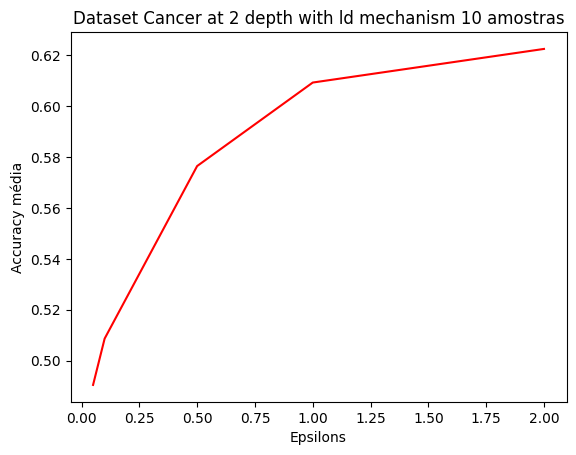

Profundidade - 5
Epsilon - 0.05
Accuracy mean - 0.44981077147016
Profundidade - 5
Epsilon - 0.1
Accuracy mean - 0.4648881483183942
Profundidade - 5
Epsilon - 0.5
Accuracy mean - 0.47206963916341066
Profundidade - 5
Epsilon - 1.0
Accuracy mean - 0.46259135830843484
Profundidade - 5
Epsilon - 2.0
Accuracy mean - 0.4632011798054087


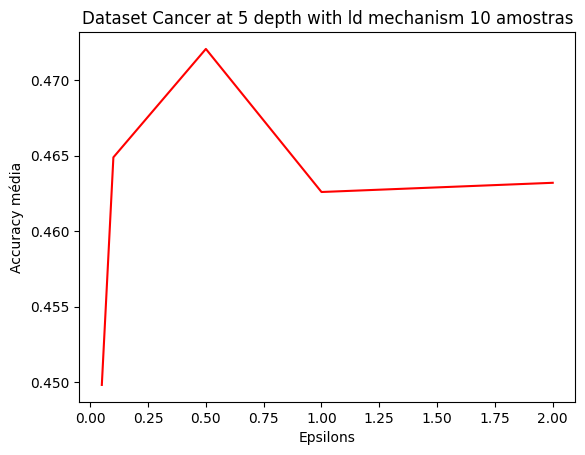

In [204]:
epsilons = [0.05, 0.1, 0.5, 1., 2.]
depths = [2,5]
results_cancer = make_test(cancer_data, "Class", epsilons, depths, "ld", name_dataset = "Cancer")

Profundidade - 2
Epsilon - 0.05
Accuracy mean - 0.6738080940643567
Profundidade - 2
Epsilon - 0.1
Accuracy mean - 0.6563415980089564
Profundidade - 2
Epsilon - 0.5
Accuracy mean - 0.5403109523569986
Profundidade - 2
Epsilon - 1.0
Accuracy mean - 0.5502026158497806
Profundidade - 2
Epsilon - 2.0
Accuracy mean - 0.5501681447686598


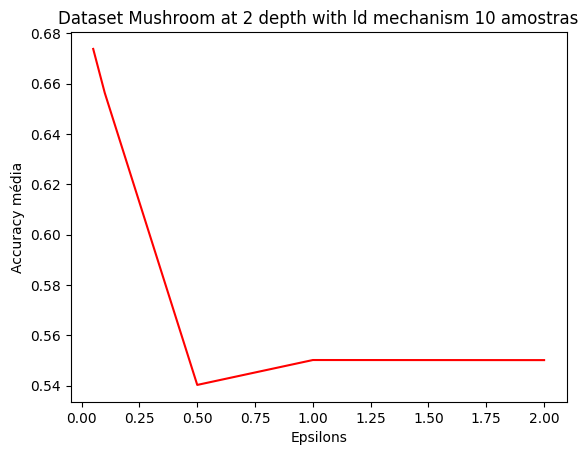

Profundidade - 5
Epsilon - 0.05
Accuracy mean - 0.5705193964768683
Profundidade - 5
Epsilon - 0.1
Accuracy mean - 0.5588582122466431
Profundidade - 5
Epsilon - 0.5
Accuracy mean - 0.6519154632853418
Profundidade - 5
Epsilon - 1.0
Accuracy mean - 0.6515447685399772
Profundidade - 5
Epsilon - 2.0
Accuracy mean - 0.6385906320701273


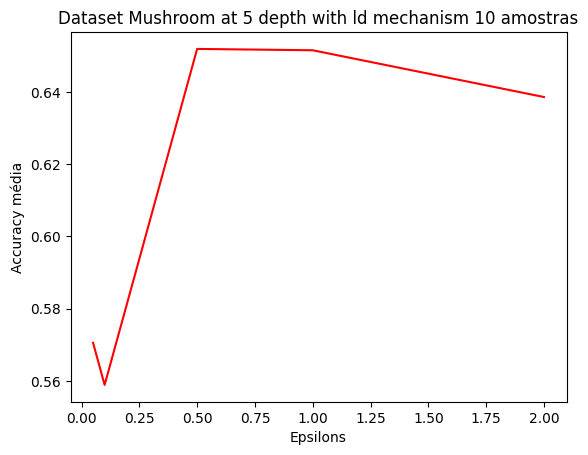

In [224]:
epsilons = [0.05, 0.1, 0.5, 1., 2.]
depths = [2,5]
results_cogumelos = make_test(cogumelos_cleaned, "poisonous", epsilons, depths, "ld", name_dataset = "Mushroom", n_folds=10)

Profundidade - 2
Epsilon - 0.05
Accuracy mean - 0.6944457103868795
Profundidade - 2
Epsilon - 0.1
Accuracy mean - 0.7796622890689839
Profundidade - 2
Epsilon - 0.5
Accuracy mean - 0.8534025775713261
Profundidade - 2
Epsilon - 1.0
Accuracy mean - 0.8572072065820505
Profundidade - 2
Epsilon - 2.0
Accuracy mean - 0.8572069921532824


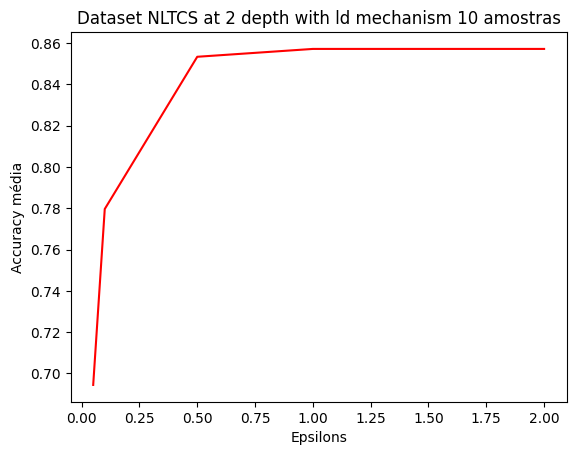

KeyboardInterrupt: 

In [448]:
epsilons = [0.05, 0.1, 0.5, 1., 2.]
depths = [2,5]
results_cogumelos = make_test(data_nltcs, "target", epsilons, depths, "ld", name_dataset = "NLTCS", n_folds=10)

# Algoritmo 5

saida: o indíce do valor mais próximo da mediana

entrada: vetor x, com todos valores entre 0 e $\Lambda$

In [206]:
def local_sensivity_at_0_alg5(x:list, idx:int, param):
    m = param[1]
    def p(x, i):
        if i > m:
            return param[0] - x[i]
        if i == m:
            return param[0] - x[m + 1]
        return param[0] + x[i] - 3 * x[m] + x[m + 1]
    def q(x,i):
        if i > m:
            return x[i]
        if i == m:
            return x[m - 1]
        return 3 * x[m] - x[m - 1] - x[i]
    
    values = [np.abs(x[m] - x[idx]), x[m + 1] - x[m], x[m] - x[m - 1], p(x,idx), q(x,idx)]

    return max(values)

def copy_and_replace(x, idx, val):
    new_x = x.copy()
    if not idx and not val: return new_x
    new_x[idx] = val
    return np.sort(new_x)
    
def get_canditates_alg5(x, t, idx, param):
    if t == 0:
        return [x]
    m = int(np.ceil((len(x))/2))
    if t == 1:
        X = []
        X.append(copy_and_replace(x, idx, param[0]))
        X.append(copy_and_replace(x))
        X.append(copy_and_replace(x, idx, 0))
        X.append(copy_and_replace(x))
        X.append(copy_and_replace(x, m, param[0]))
        X.append(copy_and_replace(x, m, 0))
        return X
    X = get_canditates_alg5(x, t - 1, idx, param[0])
    return [copy_and_replace(i, m, param[0]) if m % 2 == 1 else copy_and_replace(i, m, 0) for i in X]

def local_sensivity_at_tDistance_alg5(x, t, i, param):
    list_candidates = get_canditates_alg5(x, t, i, param)
    return max([local_sensivity_at_0_alg5(candidate, i, param) for candidate in list_candidates])

def score_func_alg5(x, idx, param):
    m = param[1]
    return -np.abs(x[m] - x[idx])

## Avalaiando

In [207]:
def avaliation(x, score_func, list_outputs, epsilon_range, quantil, typo_mech, max_u = None, n_amostras = 10000, delta_func = None):
    data_exp = []
    data_paf = []
    data_ldm = []
    for epsilon in tqdm(epsilon_range, desc="Processando epsilons", unit=" valor"):
        if typo_mech == "exp":
            err = [exp_mechanism_k(x, score_func, list_outputs, epsilon, max_u[0], max_u) for i in range(n_amostras)]
            erro_abs = [np.abs(quantil - i) for i in err]
            mean_err = np.mean(erro_abs)
            data_exp.append(mean_err)
        elif typo_mech == "paf":
            err = [permute_and_flip_k(x, score_func, list_outputs, epsilon, max_u[0], max_u) for i in range(n_amostras)]
            erro_abs = [np.abs(quantil - i) for i in err]
            mean_err = np.mean(erro_abs)
            data_paf.append(mean_err)
        elif typo_mech == "ld":
            err = [local_dampening_mechanism_k(x, score_func, delta_func, list_outputs, epsilon, max_u) for i in range(n_amostras)]
            erro_abs = [np.abs(quantil - i) for i in err]
            mean_err = np.mean(erro_abs)
            data_ldm.append(mean_err)
        else:
            err = [exp_mechanism_k(x, score_func, list_outputs, epsilon, max_u[0], max_u) for i in range(n_amostras)]
            erro_abs = [np.abs(quantil - i) for i in err]
            mean_err = np.mean(erro_abs)
            data_exp.append(mean_err)

            err = [permute_and_flip_k(x, score_func, list_outputs, epsilon, max_u[0], max_u) for i in range(n_amostras)]
            erro_abs = [np.abs(quantil - i) for i in err]
            mean_err = np.mean(erro_abs)
            data_paf.append(mean_err)

            err = [local_dampening_mechanism_k(x, score_func, delta_func, list_outputs, epsilon, max_u) for i in range(n_amostras)]
            erro_abs = [np.abs(quantil - i) for i in err]
            mean_err = np.mean(erro_abs)
            data_ldm.append(mean_err)

    if len(data_paf) > 0:
        plt.plot(epsilon_range, data_paf, linestyle = "-", marker = "o",color = "blue", label = "PermuteAndFlip")
    if len(data_exp) > 0:
        plt.plot(epsilon_range, data_exp, linestyle = "-", marker = "o",color = "black", label = "Exponencial")
    if len(data_ldm) > 0:
        plt.plot(epsilon_range, data_ldm, linestyle = "-", marker = "o",color = "red", label = "LocalDampening")
    plt.legend()
    plt.title(f"Plot {n_amostras} amostras")
    plt.xlabel("Epsilon")
    plt.ylabel("Erro médio")
    plt.xscale('log')
    plt.grid(True)
    plt.show()

    return data_exp, data_paf, data_ldm

In [220]:
epsilons = np.linspace(10**-1, 10**2, 10)
n_array = 100

lam = 10**6
percent = 50
quantil = int(np.ceil(percent/ 100 * n_array))
parameters = [lam, quantil]
array_aleatorio = np.sort(np.random.rand(n_array) * lam)
n_amostras = 1000
list_outputs = [i for i in range(n_array)]
max_utility = max(score_func_alg5(array_aleatorio, i, parameters) for i in range(n_array))

Processando epsilons: 100%|██████████| 10/10 [00:12<00:00,  1.26s/ valor]


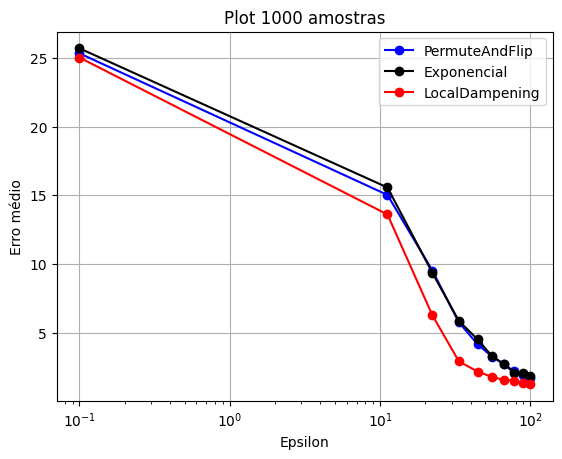

In [221]:
evalueate = avaliation(array_aleatorio, 
                           score_func_alg5, 
                           list_outputs, 
                           epsilons, 
                           quantil,
                           max_u = parameters,
                           typo_mech = "todos",
                           n_amostras=n_amostras,
                           delta_func=local_sensivity_at_tDistance_alg5)

In [210]:
%pip install scipy

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


([25.694, 15.56, 9.342, 5.856, 4.497, 3.279, 2.708, 2.078, 2.049, 1.855], [25.329, 15.018, 9.51, 5.748, 4.148, 3.24, 2.682, 2.194, 1.9, 1.68], [25.022, 13.596, 6.251, 2.911, 2.153, 1.773, 1.544, 1.497, 1.342, 1.227])


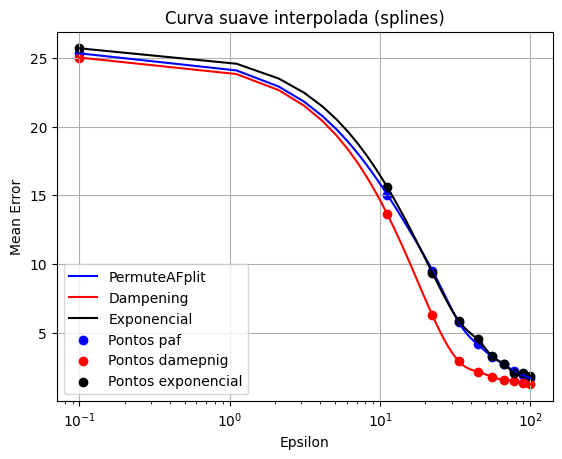

In [222]:
from scipy.interpolate import interp1d

print(evalueate)
epp, paf, ldm = evalueate

interp_func_epp = interp1d(epsilons, epp, kind='cubic')
interp_func_paf = interp1d(epsilons, paf, kind='cubic')
interp_func_ldm = interp1d(epsilons, ldm, kind='cubic')

# Gerar mais pontos para a curva suave
epsilon_smooth = np.linspace(min(epsilons), max(epsilons), 100)
mean_err_smooth_epp = interp_func_epp(epsilon_smooth)
mean_err_smooth_paf = interp_func_paf(epsilon_smooth)
mean_err_smooth_ldm= interp_func_ldm(epsilon_smooth)

# Plotar a curva suave
plt.figure()
plt.plot(epsilon_smooth, mean_err_smooth_paf, label='PermuteAFplit', color='blue')
plt.plot(epsilon_smooth, mean_err_smooth_ldm, label='Dampening', color='red')
plt.plot(epsilon_smooth, mean_err_smooth_epp, label='Exponencial', color='black')
plt.scatter(epsilons, paf, marker='o', color='blue', label='Pontos paf')
plt.scatter(epsilons, ldm, marker='o', color='red', label='Pontos damepnig')
plt.scatter(epsilons, epp, marker='o', color='black', label='Pontos exponencial')
plt.xscale('log')  # Escala logarítmica no eixo x
plt.xlabel('Epsilon')
plt.ylabel('Mean Error')
plt.title('Curva suave interpolada (splines)')
plt.legend()
plt.grid(True)
plt.show()